In [1]:
    import fiona
    import os,os.path
    from shapely.geometry import shape,mapping
    from shapely.ops import transform
    from functools import partial
    import pyproj
    from fiona.crs import from_epsg
    import osmnx as ox
    import matplotlib.pyplot as plt
    import geopandas as gpd
    import glob
    import json
    import numpy as np
    import collections

In [2]:
from platform import python_version
print(python_version())

2.7.12


In [3]:
def createPoints(root_Dir, inshp , outshp, mini_dist):
    
    '''
    This function will parse through the street network of provided city and
    clean all highways and create points every mini_dist meters (or as specified) along
    the linestrings
    Required modules: Fiona and Shapely

    parameters:
        inshp: the input linear shapefile, must be in WGS84 projection, ESPG: 4326
        output: the result point feature class
        mini_dist: the minimum distance between two created point

    last modified by Xiaojiang Li, MIT Senseable City Lab
    
    '''
    inshp = root_Dir + inshp
    outshp = root_Dir + outshp
    input_crs = ''
    count = 0
    s = {'trunk_link','tertiary','motorway','motorway_link','steps', None, ' ','pedestrian','primary', 'primary_link','footway','tertiary_link', 'trunk','secondary','secondary_link','tertiary_link','bridleway','service'}
    
    # the temporaray file of the cleaned data
    root = os.path.dirname(root_Dir)
    basename = 'clean_' + os.path.basename(inshp)
    temp_cleanedStreetmap = os.path.join(root,basename)
    c = fiona.open(inshp)
    input_crs = c.crs['init']
    c.close()
    # if the tempfile exist then delete it
    if os.path.exists(temp_cleanedStreetmap):
        fiona.remove(temp_cleanedStreetmap, 'ESRI Shapefile')
    
    # clean the original street maps by removing highways, if it the street map not from Open street data, users'd better to clean the data themselve
    with fiona.open(inshp) as source, fiona.open(temp_cleanedStreetmap, 'w', driver=source.driver, crs=source.crs,schema=source.schema) as dest:
        for feat in source:
            try:
                i = feat['properties']['highway'] # for the OSM street data
                if i in s:
                    continue
            except:
                # if the street map is not osm, do nothing. You'd better to clean the street map, if you don't want to map the GVI for highways
                key = dest.schema['properties'].keys()[0] # get the field of the input shapefile and duplicate the input feature
                i = feat['properties'][key]
                if i in s:
                    continue
            
            dest.write(feat)

    schema = {
        'geometry': 'Point',
        'properties': {'id': 'int'},
    }

    # Create pointS along the streets
    with fiona.drivers():
        #with fiona.open(outshp, 'w', 'ESRI Shapefile', crs=source.crs, schema) as output:
        with fiona.open(outshp, 'w', crs = from_epsg(4326), driver = 'ESRI Shapefile', schema = schema) as output:
            for line in fiona.open(temp_cleanedStreetmap):
                first = shape(line['geometry'])
                
                length = first.length
                
                try:
                    # convert degree to meter, in order to split by distance in meter
                    project = partial(pyproj.transform,pyproj.Proj(init=input_crs),pyproj.Proj(init='EPSG:3857')) #3857 is psudo WGS84 the unit is meter
                    
                    line2 = transform(project, first)
                    linestr = list(line2.coords)
                    dist = mini_dist #set
                    for distance in range(0,int(line2.length), dist):
                        point = line2.interpolate(distance)
                        
                        # convert the local projection back the the WGS84 and write to the output shp
                        project2 = partial(pyproj.transform,pyproj.Proj(init='EPSG:3857'),pyproj.Proj(init='EPSG:4326'))
                        point = transform(project2, point)
                        output.write({'geometry':mapping(point),'properties': {'id':1}})
                except:
                    print ("You should make sure the input shapefile is WGS84")
                    return
                    
    print("Process Complete")
    
    # delete the temprary cleaned shapefile
    fiona.remove(temp_cleanedStreetmap, 'ESRI Shapefile')


In [102]:
place_name = "Greater London"
graph = ox.graph_from_place(place_name,network_type='drive')
# # buildings = ox.buildings_from_place(place_name)
nodes, edges = ox.graph_to_gdfs(graph)

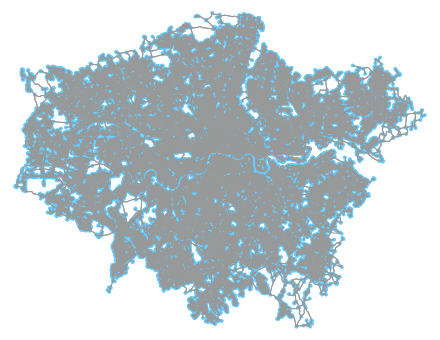

In [103]:
fig, ax = ox.plot_graph(graph)

In [ ]:
# G_projected = ox.project_graph(graph)
ox.save_graph_shapefile(graph, filename='GreaterLondon')

In [4]:
roads = gpd.read_file('data/GreaterLondon/edges/edges.shp')

In [5]:
len(roads)

161892

In [ ]:
%ls data/

In [107]:
edges.geometry

0           LINESTRING (0.11114 51.50256, 0.11135 51.50265)
1         LINESTRING (0.11114 51.50256, 0.11137 51.50233...
2           LINESTRING (0.11114 51.50256, 0.11067 51.50234)
3         LINESTRING (-0.17874 51.62218, -0.17824 51.62217)
4         LINESTRING (-0.17874 51.62218, -0.17881 51.622...
5         LINESTRING (-0.17874 51.62218, -0.17867 51.622...
6         LINESTRING (-0.29064 51.56510, -0.29023 51.56529)
7         LINESTRING (-0.29064 51.56510, -0.29111 51.56528)
8         LINESTRING (-0.29064 51.56510, -0.29040 51.564...
9         LINESTRING (0.11180 51.50211, 0.11137 51.50233...
10        LINESTRING (-0.29111 51.56528, -0.29064 51.56510)
11        LINESTRING (-0.28906 51.51213, -0.28999 51.512...
12        LINESTRING (-0.28906 51.51213, -0.28886 51.51211)
13        LINESTRING (-0.28906 51.51213, -0.28900 51.512...
14        LINESTRING (-0.06706 51.46475, -0.06717 51.46472)
15        LINESTRING (-0.41305 51.60681, -0.41215 51.606...
16        LINESTRING (-0.41305 51.60681,

In [90]:
roads = gpd.read_file('../Data/'+place_name+'/edges/edges.shp')

In [91]:
c = fiona.open('../Data/'+place_name+'/edges/edges.shp')
crs = c.crs
print crs

{'init': u'epsg:32630'}


In [ ]:
root = '../Data/'+place_name+'/edges/'
createPoints(root , 'edges.shp', 'samples.shp',200)

In [26]:
points_samples = gpd.read_file('../Data/'+place_name+'/edges/samples.shp')

In [27]:
points_samples.head()

,id,geometry
0,1,POINT (0.11135 51.50265)
1,1,POINT (0.11180 51.50211)
2,1,POINT (0.11067 51.50234)
3,1,POINT (-0.17824 51.62217)
4,1,POINT (-0.17977 51.62241)


In [28]:
len(roads)

161911

In [29]:
roads.head()

,access,area,bridge,est_width,from,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,geometry
0,,,,,370068561,residential,,0,,17.609,20 mph,Epstein Road,False,10780443,,,95944704,,,"LINESTRING (715931.281 5710314.614, 715917.030..."
1,,,,,95944707,residential,,0,,68.247,20 mph,Galsworthy Close,False,10780432,,,95944704,,,"LINESTRING (715964.413 5710256.225, 715934.225..."
2,,,,,95944671,residential,,0,,41.109,20 mph,Epstein Road,False,10780443,,,95944704,,,"LINESTRING (715885.341 5710277.855, 715917.030..."
3,,,,,277489,residential,,0,,29.564,30 mph,Woodside Grove,False,3398626,,,193724417,,,"LINESTRING (695323.706 5722787.895, 695294.102..."
4,,,,,277490,residential,,0,,80.433,30 mph,Woodside Grove,False,3398626,,,193724417,,,"LINESTRING (695216.776 5722810.611, 695286.927..."


In [31]:
city = '../Data/Cambridge/'
files= glob.glob(city + '*.json')

In [35]:
first = json.load(open(files[0] , 'rb'))

In [39]:
years = []
for f in files:
    record = json.load(open(f , 'rb'))
    for k in record:
        for pano in record[k]:
            if 'year' in pano:
                years.append(pano['year'])

In [73]:
pointCount = []
for f in files:
    record = json.load(open(f , 'rb'))
    for k in record:
        temp = []
        for pano in record[k]:
            if 'year' in pano:
                temp.append(pano['year'])
        pointCount.append(len(temp))

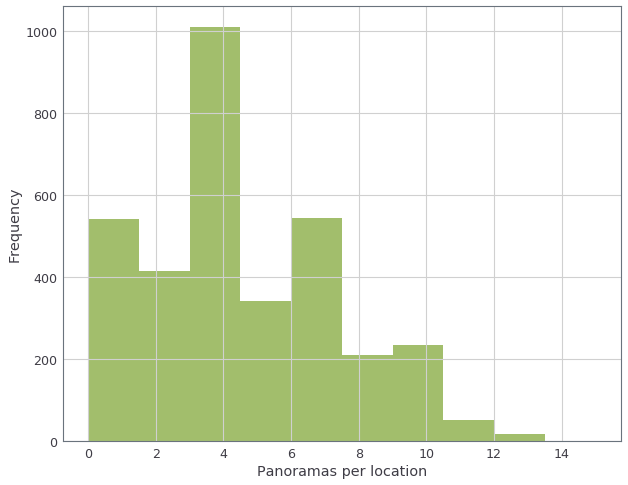

In [76]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Panoramas per location')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(pointCount, 10, facecolor='g', alpha=0.75)

In [46]:
counts = collections.Counter(years)

In [57]:
[counts[y] for y in years]

[1920, 1028, 288, 2482, 2793, 1707, 988, 1094, 1147, 1152]

In [52]:
years = sorted(counts.keys())

In [45]:
import matplotlib.pyplot as plt

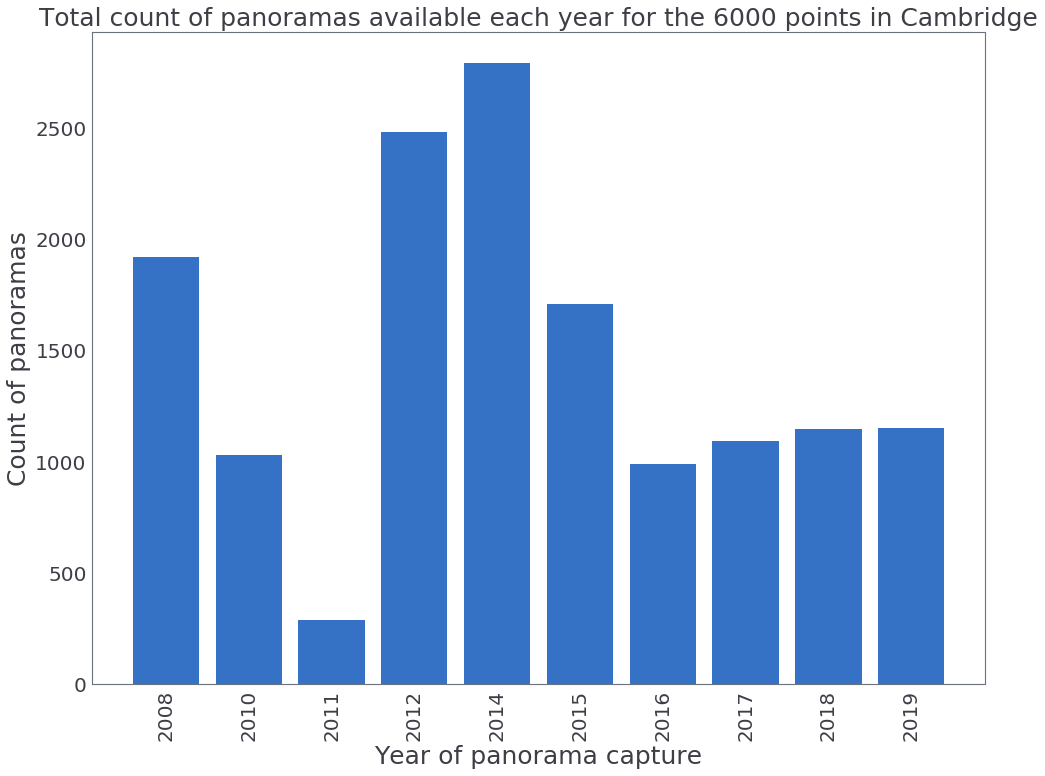

In [72]:
x = np.arange(len(years))
count = [counts[y] for y in years]
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
plt.grid()
plt.bar(x, count)
plt.title('Total count of panoramas available each year for the 6000 points in Cambridge',fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel('Count of panoramas',fontsize=25)
plt.xticks(x, years,rotation=90,fontsize=20)
plt.xlabel('Year of panorama capture',fontsize=25)
plt.show()
